In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass


import emcee

from scipy.optimize import minimize


from scipy.stats import t, norm

In [2]:
from surp import subgiants
import surp
import vice
from surp import gce_math as gcem
import arya

import sys
sys.path.append("../..")

from models.make_yields import make_yield_params

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
def sfh_linexp(tau_sfh=5, A=0):
    return lambda t: t/tau_sfh / 0.368 * np.exp(-t/tau_sfh)

In [4]:
def sfh_2in(tau1=2, tau2=5, A12=0.5, t12=5):
    def inner(t):
        s = A12 * np.exp(-t/tau1)
        s += np.where(t >=t12, np.exp(-(t-t12) / tau2), 0)
        return s
    return inner

In [5]:
def sfh_insideout(tau_rise=3, tau_sfh=15):
    return lambda t: np.exp(-t/tau_sfh) * (1 - np.exp(-t/tau_rise))

def sfh_const():
    return lambda t: 1 + 0*t

In [101]:
def sz_model(dt=0.01, t_end=13.2, tau_sfh=5, 
             eta=0.5, tau_star=2.5, mode="sfr", RIa="exp", sfh=None, **kwargs):   
    params = make_yield_params(**kwargs)
    surp.set_yields(params)
    
    if sfh is None:
        sfh = sfh_linexp(tau_sfh )
        
    sz = vice.singlezone(elements=["o", "mg", "c", "fe", "n"], func=sfh, mode=mode, dt=dt, 
                         eta=eta,  
                         tau_star=tau_star,
                         Mg0=1) # total gas mass should not actually matter??
    
    sz.RIa = RIa
    out = sz.run(np.arange(0, t_end, dt), capture=True, overwrite=True)
    return out

In [7]:
def calc_model(**params):
    sz = sz_model(**params)
    zo_a = np.array(sz.history["z(o)"])[2:]
    zfe_a = np.array(sz.history["z(fe)"])[2:]
    zc_a = np.array(sz.history["z(c)"])[2:]

    o_h_a = gcem.abund_to_brak(zo_a, "o")
    c_o_a = gcem.abund_to_brak(zc_a/zo_a, "c", "o")
    o_fe_a = gcem.abund_to_brak(zo_a/zfe_a, "o", "fe")
    
    return o_fe_a, c_o_a, np.array(sz.history["sfr"][2:])

In [8]:
def plot_sz(label="", **kwargs,):
    x, y, w = calc_model(**kwargs)
    plt.scatter(x, y, s=w, label=label)
    plt.xlabel("[Mg/Fe]")
    plt.ylabel("[C/Mg]")
    arya.Legend(loc=-1, color_only=True)

# Simple modeling

## AGB Yield properties

In [96]:
sz = sz_model()

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

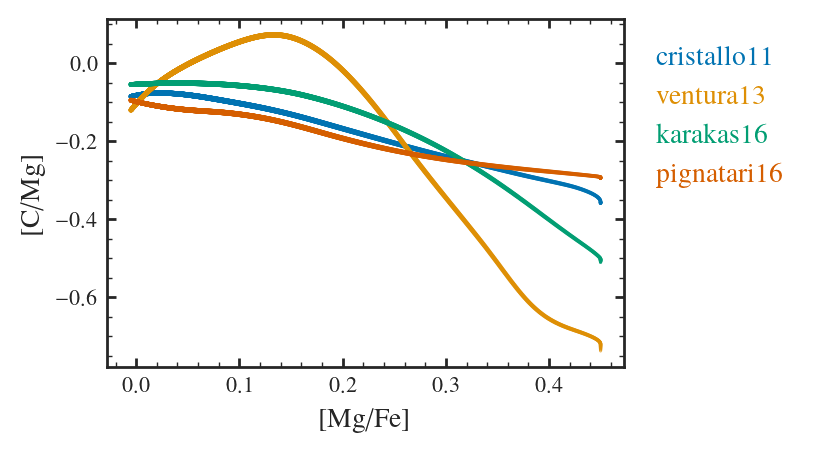

In [19]:
for model in surp.AGB_MODELS:
    plot_sz(label=model, agb_model=model)

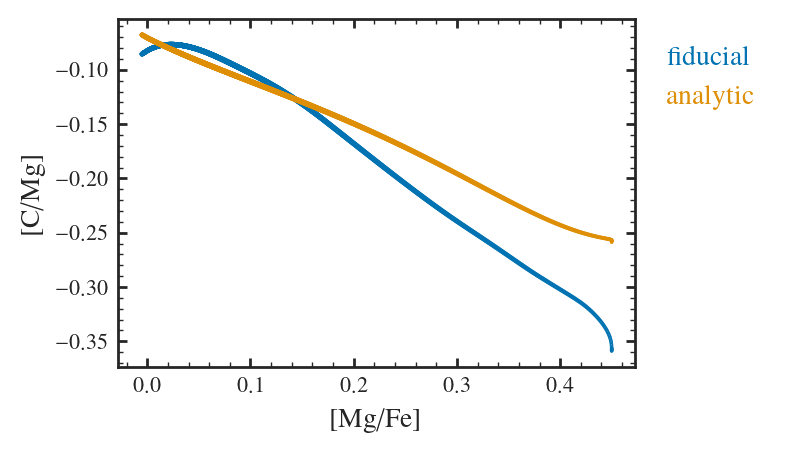

In [20]:
plot_sz(label="fiducial")
plot_sz(agb_model="A", zeta_agb=0, label="analytic", t_D=0.2)

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

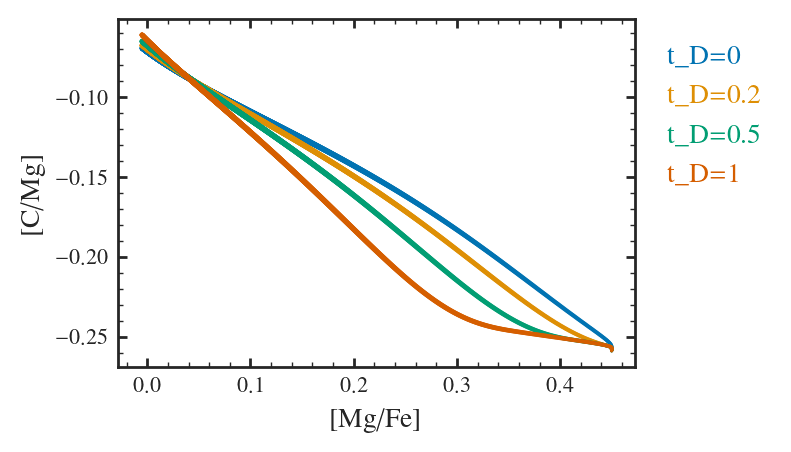

In [28]:
for model in [0, 0.2, 0.5, 1]:
    plot_sz(label=f"t_D={model}", agb_model="A", zeta_agb=0, t_D=model)

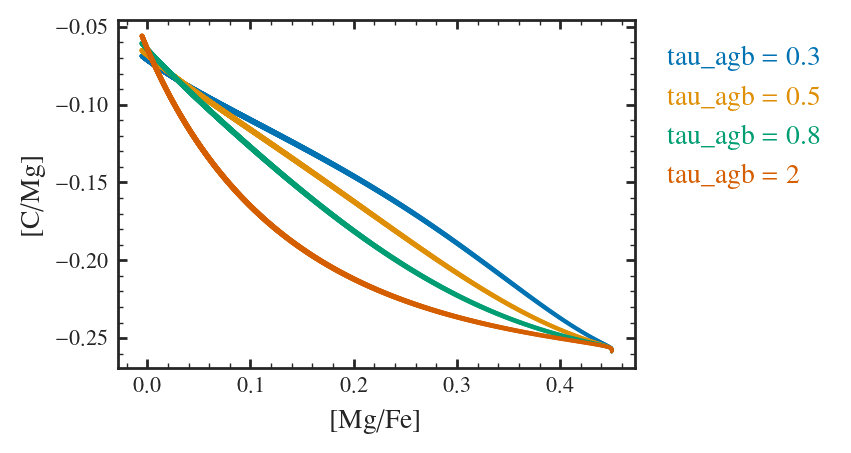

In [26]:
for model in [0.3, 0.5, 0.8, 2]:
    plot_sz(label=f"tau_agb = {model}", agb_model="A", zeta_agb=0, tau_agb=model)

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

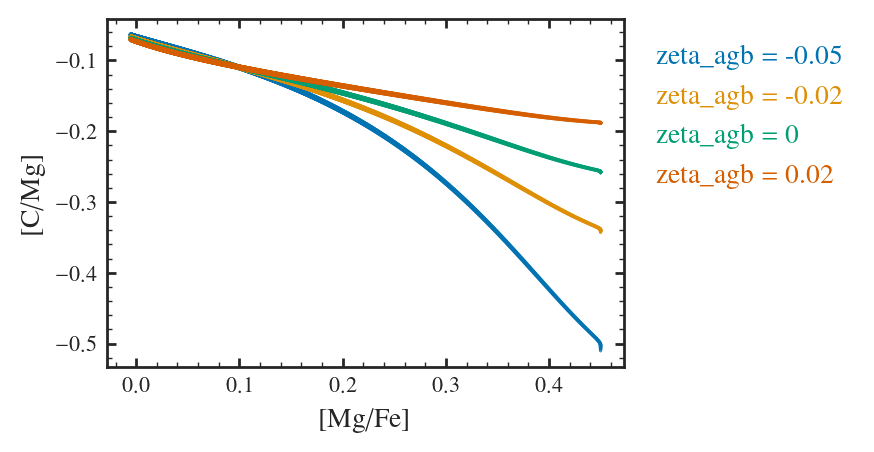

In [32]:
for model in [-0.05, -0.02, 0, 0.02]:
    plot_sz(label=f"zeta_agb = {model}", agb_model="A", zeta_agb=model)
    

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

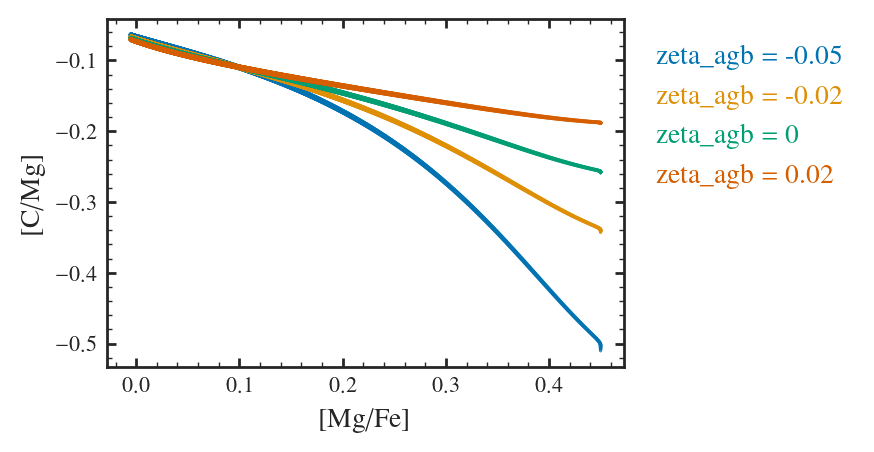

In [32]:
for model in [-0.05, -0.02, 0, 0.02]:
    plot_sz(label=f"zeta_agb = {model}", agb_model="A", zeta_agb=model)
    

## CCSNe

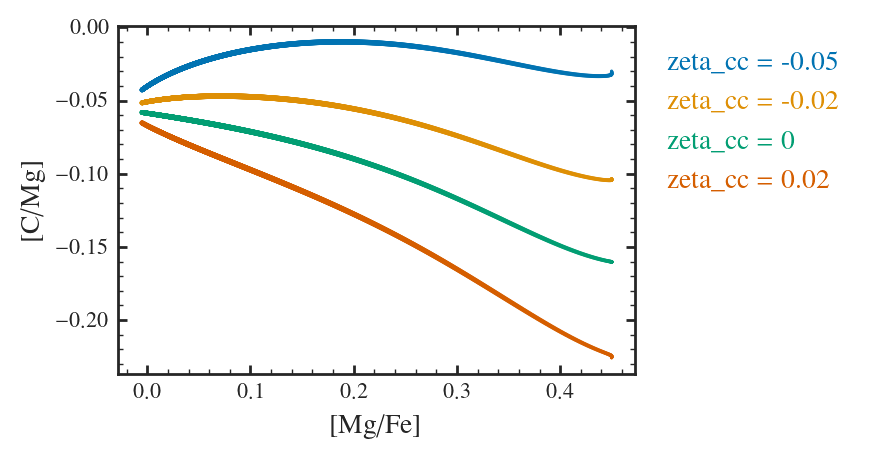

In [57]:
for model in [-0.05, -0.02, 0, 0.02]:
    plot_sz(label=f"zeta_cc = {model}", zeta_cc=model, agb_model="A", zeta_agb=0)
    

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

(-1.0, 0.09574755986929767)

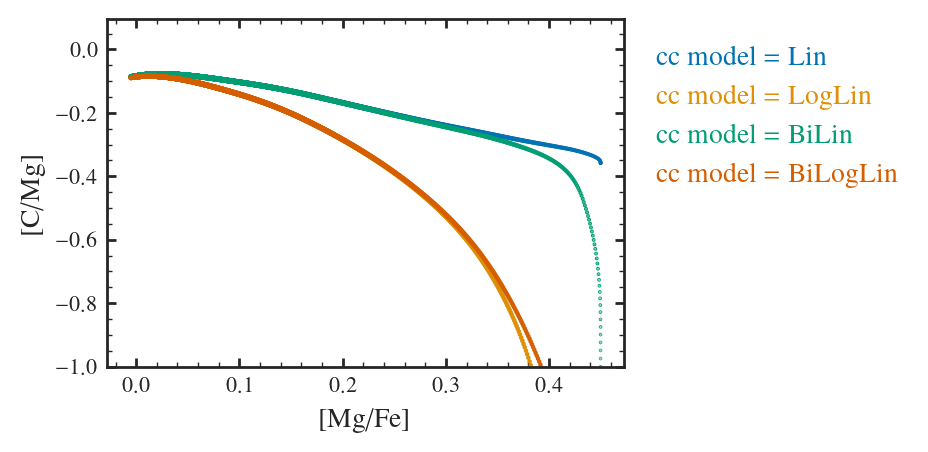

In [56]:
for model in ["Lin", "LogLin", "BiLin", "BiLogLin"]:
    plot_sz(label=f"cc model = {model}", cc_model=model, Z1=0.001)

plt.ylim(-1)

## Iron

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

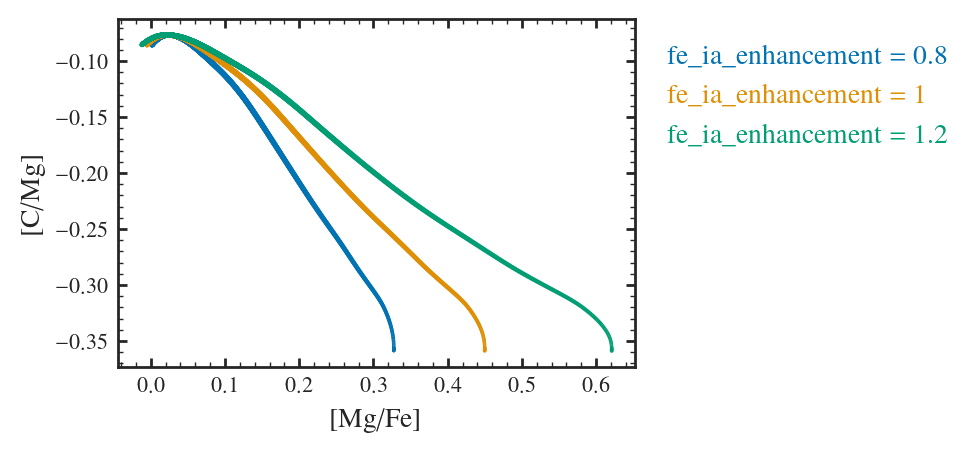

In [35]:
for model in [0.8, 1, 1.2]:
    plot_sz(label=f"fe_ia_enhancement = {model}", fe_ia_factor=model)
    

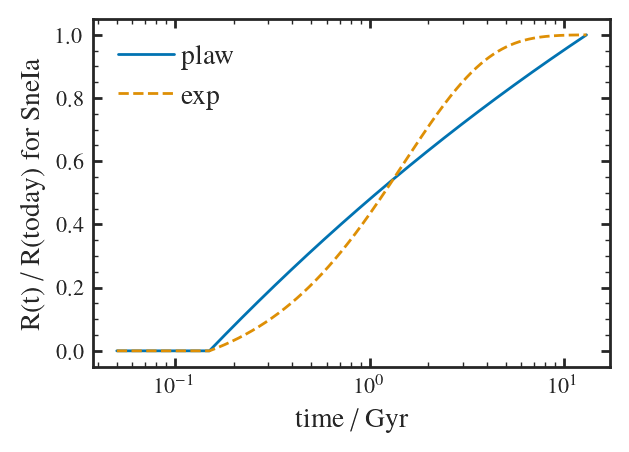

In [93]:
def dtd_1(t):
    return np.where(t > 0.15, t**(-1.1), 0)

def dtd_2(t):
    return np.where(t > 0.15, np.exp(-(t-0.15) * al), 0)

t = np.logspace(-1.3, np.log10(13), 1000)
dt = np.gradient(t)
R1 = np.cumsum(dtd_1(t)*dt)
R2 = np.cumsum(dtd_2(t)*dt)

plt.plot(t, R1 / R1[-1], label="plaw")
plt.plot(t, R2 / R2[-1], label="exp", ls="--")

plt.xscale("log")
plt.xlabel("time / Gyr")
plt.ylabel("R(t) / R(today) for SneIa ")
plt.legend()

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

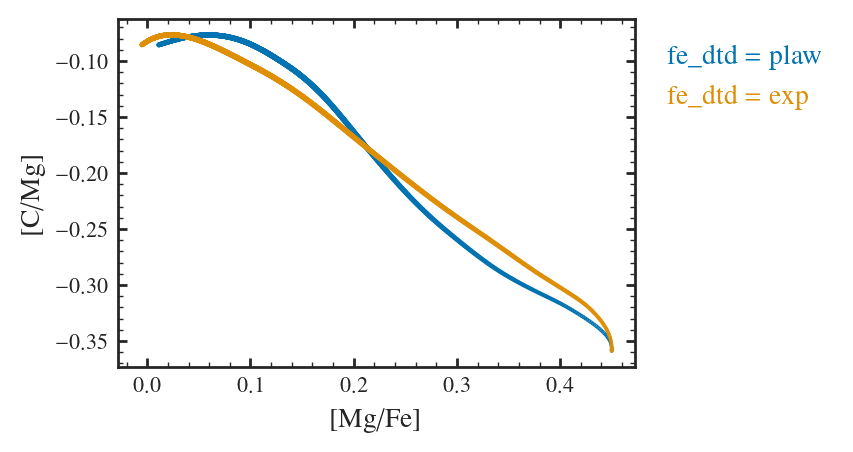

In [94]:
for model in ["plaw", "exp"]:
    plot_sz(label=f"fe_dtd = {model}", RIa=model)
    

## GCE Parameters

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

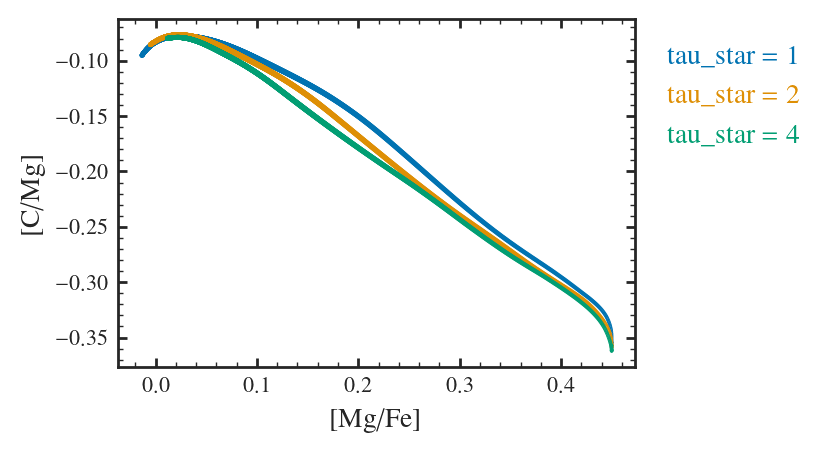

In [39]:
for model in [1, 2, 4]:
    plot_sz(label=f"tau_star = {model}", tau_star=model)
    

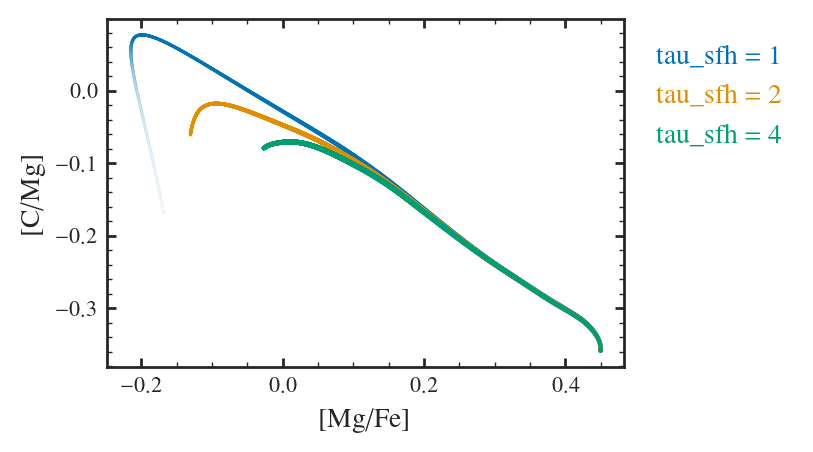

In [40]:
for model in [1, 2, 4]:
    plot_sz(label=f"tau_sfh = {model}", tau_sfh=model)
    

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

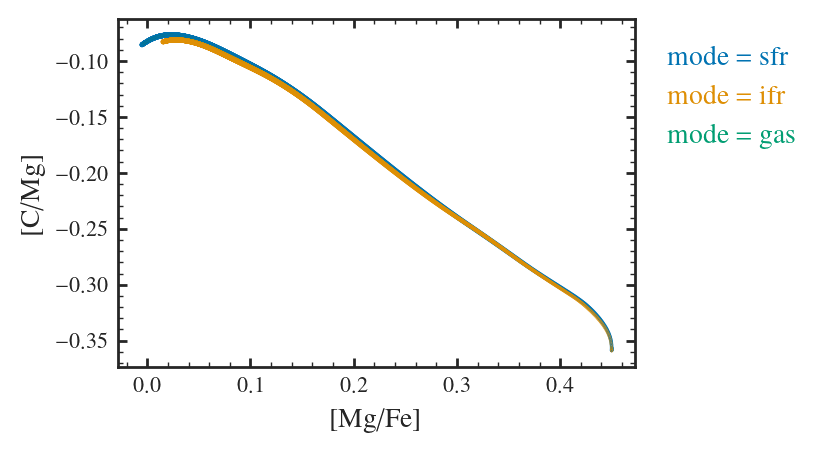

In [49]:
for model in ["sfr", "ifr", "gas"]:
    plot_sz(label=f"mode = {model}", mode=model)
    

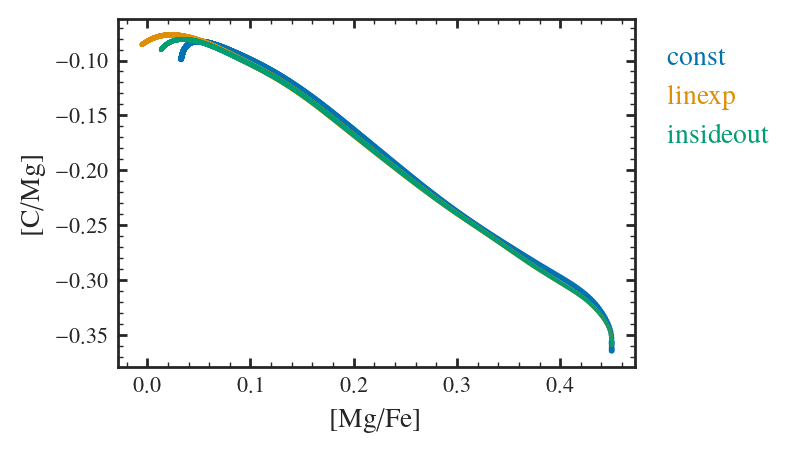

In [44]:
plot_sz(label=f"const", sfh=sfh_const())
plot_sz(label=f"linexp", sfh=sfh_linexp())
plot_sz(label=f"insideout", sfh=sfh_2exp())

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

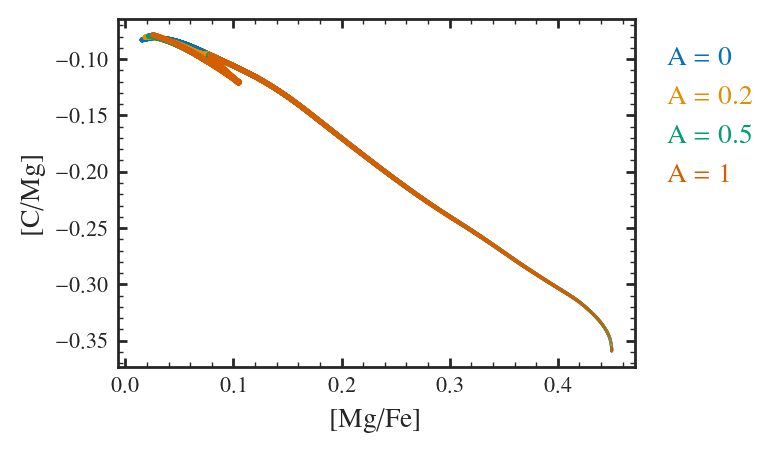

In [58]:
for model in [0, 0.2, 0.5, 1]:
    plot_sz(label=f"A = {model}", A=model, mode="ifr")
    

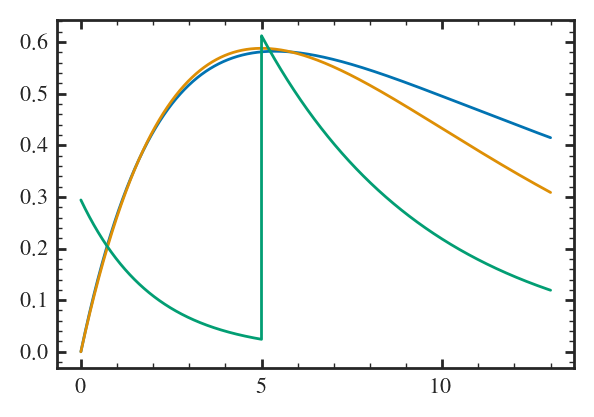

In [74]:
t = np.linspace(0, 13, 10000)
plt.plot(t, sfh_insideout()(t), label="insideout")
plt.plot(t, sfh_linexp()(t)/1.7, label="linexp")
plt.plot(t, sfh_2in()(t)/1.7, label="linexp")

In [50]:
tau_star=lambda t: surp.simulation.properties.conroy_sf_law(1)(t, 1), 


In [97]:
def tau_star_2in(nu1=1.3, nu2=0.7, t12=5):
    return lambda t: 1/np.where(t < t12, nu1, nu2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


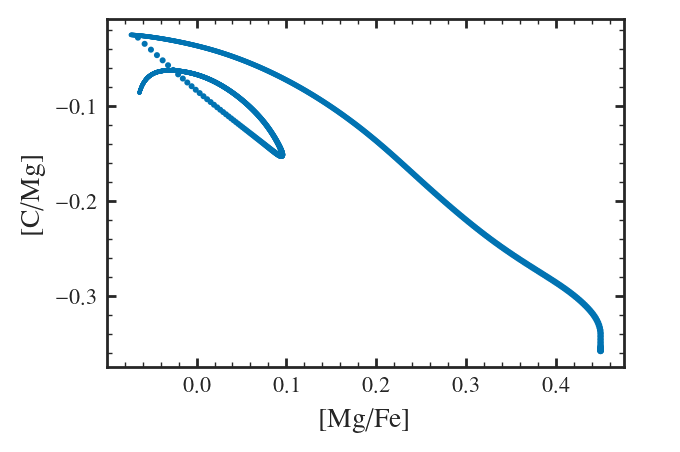

In [99]:
plot_sz(sfh=sfh_2in(A12=2, tau1=3, t12=5), tau_star=tau_star_2in())

## Bimodality

In [106]:
t12 = 7

In [104]:
kwargs = dict(agb_model="A", zeta_agb=0, f_agb=0.5)
sz1 = sz_model(**kwargs)
sz2 = sz_model(tau_sfh=3, tau_star=0.7, eta=0, t_end=t12, RIa="exp", **kwargs)

filt = np.array(sz1.history["time"]) > t12 - 2
h1 = pd.DataFrame(sz1.history.todict())[filt]
h1["[mg/fe]"] = -h1["[fe/mg]"]

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

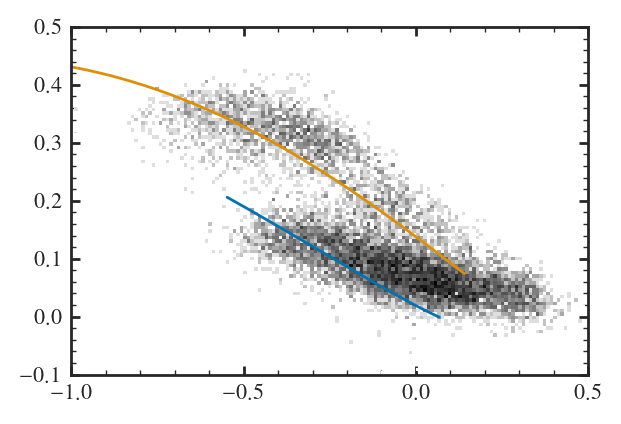

(-0.5, 0.1)

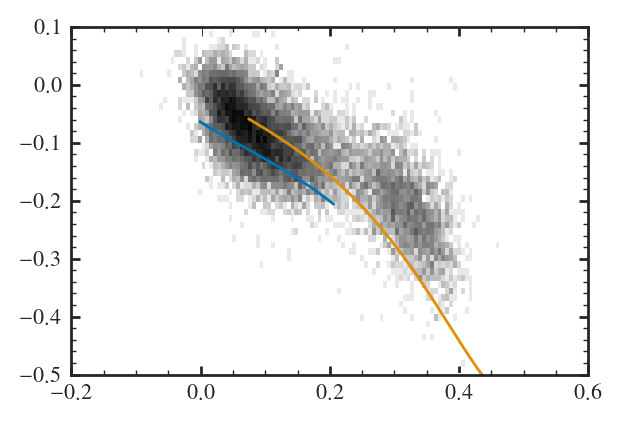

In [105]:

plt.plot(h1["[fe/h]"], h1["[mg/fe]"])
plt.plot(sz2.history["[fe/h]"], sz2.history["[mg/fe]"])
plt.hist2d(subgiants.FE_H, subgiants.MG_FE, 300, cmap="Greys", norm="log");
plt.xlim(-1, 0.5)
plt.ylim(-0.1, 0.5)
plt.show()


plt.plot(h1["[mg/fe]"], h1["[c/mg]"])
plt.plot(sz2.history["[mg/fe]"], sz2.history["[c/mg]"])
plt.hist2d(subgiants.MG_FE, subgiants.C_MG, 300, cmap="Greys", norm="log");
plt.xlim(-0.2, 0.6)
plt.ylim(-0.5, 0.1)

# MCMC attempts

In [8]:
def prob(x, y, xerr, yerr, xm, ym):
    return np.exp(-1/2 * ((y - ym)**2/yerr**2 + (x-xm)**2/xerr**2))

In [9]:
def log_prob(obs, model):
    x, y, xerr, yerr = obs
    xm, ym, w = model
    xm = xm.reshape((-1, 1))
    ym = ym.reshape((-1, 1))
    w = w.reshape((-1, 1)) 
    Σs = np.sum(w * prob(x, y, xerr, yerr, xm, ym), axis=0) # sum over model
    return np.sum(np.log(Σs)) # return log product of each data point
    
    

In [10]:
def normal(x, mu, sigma):
    return 1/np.sqrt(2*np.pi * sigma**2) * np.exp(-(x-mu)**2 / (2*sigma**2))

In [11]:
def log_normal(x, mu, sigma):
    return np.where(x >= 0, normal(np.log(x), np.log(mu), sigma), 0)

In [54]:
class SZModel:
    def __init__(self):
        self.eta = 2
        self.tau_agb = 0.5
        self.f_agb = 0.2
        self.A = 0
        self.t_b = 8
        self.tau_b = 2
        self.tau_sfh = 5
    
    def set_params(self, theta):
        self.eta, self.tau_agb, self.f_agb = theta
        
    
    def log_prior(self):
        p = 0
        p += np.log(log_normal(self.eta, 0.5, 2))
        p += np.log(log_normal(self.tau_agb, 2, 0.5))
        p += np.log(normal(self.f_agb, 0.2, 0.1))

        return p
    
    def predict(self):
        return calc_model(eta=self.eta, tau_agb=self.tau_agb, f_agb=self.f_agb, 
                          tau_b=self.tau_b, A=self.A, t_b=self.t_b, tau_sfh=self.tau_sfh)
        
    def get_params(self):
        return [self.eta, self.tau_agb, self.f_agb]

    def log_likelihood(self, theta, obs):
        self.set_params(theta)
        model = self.predict()
        return log_prob(obs, model) + self.log_prior()

In [55]:
def plot_model(model, theta, **kwargs):
    model.set_params(theta)
    x, y, w = model.predict()
    plt.scatter(x, y, s=w, **kwargs)

In [56]:
x = subgiants.MG_FE
y = subgiants.C_MG
xerr = subgiants.MG_FE_ERR
yerr = subgiants.C_MG_ERR

filt = ~np.isnan(x)
filt &= ~np.isnan(y)
filt &= ~np.isnan(xerr)
filt &= ~np.isnan(yerr)
print(np.sum(~filt))
filt &= ~subgiants.high_alpha

x = x[filt].values
y = y[filt].values
xerr = xerr[filt].values
yerr = yerr[filt].values

obs = [x, y, xerr, yerr]

0


In [57]:
model = SZModel()
model.t_b = 5
model.tau_sfh = 5
model.tau_b = 2
model.A = 0
model.f_agb = 0.2
model.eta= 1
th0 = model.get_params()


(-0.5, 0.2)

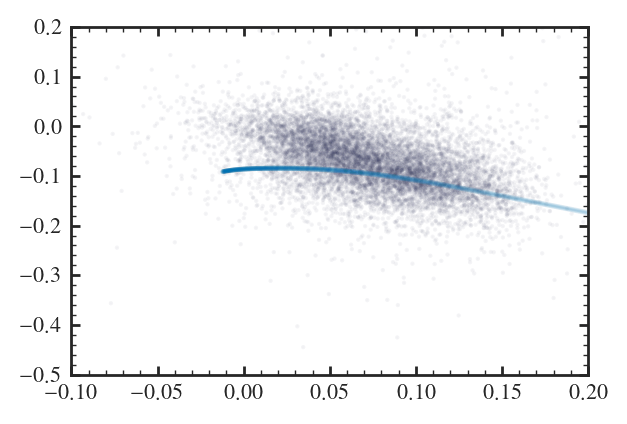

In [58]:
plt.scatter(x, y, s=0.3, alpha=0.05, c=subgiants.high_alpha[filt])
plot_model(model, th0, alpha=0.05)
plt.xlim(-0.1, 0.2)
plt.ylim(-0.5, 0.2)

In [59]:
model = SZModel()
model.t_b = 0
model.tau_sfh = 4
model.tau_b = 1
model.A = 0.1
model.f_agb = 0.3
model.eta= 0.
th0 = model.get_params()


/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:258: ScienceWarning: Closed-box GCE models have been shown to overpredict the metallicities of solar neighborhood stars. This was known as the G-dwarf problem (Tinsley 1980, Fundamentals of Cosmic Phys., 5, 287). Outflows have been shown to be necessary for maintaining long-term chemical equilibrium (Dalcanton 2007, ApJ, 658, 941).
  self.__c_version = c_singlezone(**kwargs)


(-0.5, 0.2)

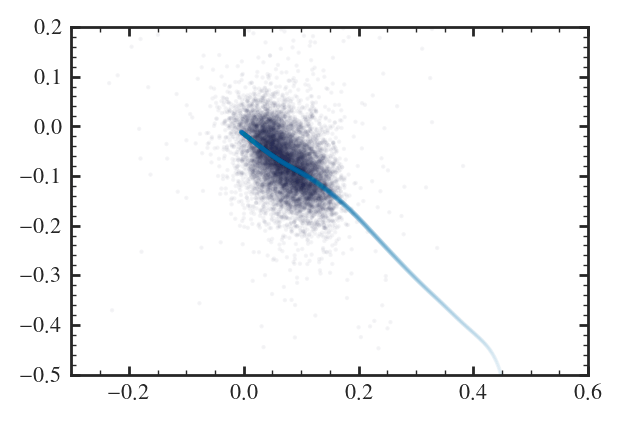

In [60]:
plt.scatter(x, y, s=0.3, alpha=0.05, c=subgiants.high_alpha[filt])
plot_model(model, th0, alpha=0.05)
plt.xlim(-0.3, 0.6)
plt.ylim(-0.5, 0.2)

In [64]:
model = SZModel()
th0 = model.get_params()

In [ ]:
nll = lambda args, obs: -model.log_likelihood(args, obs)

Nparams = len(th0)

initial = th0 * (1 +  0.02 * np.random.randn(Nparams))
soln = minimize(nll, initial, args=obs)

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

In [63]:
soln.x / initial

ValueError: operands could not be broadcast together with shapes (4,) (3,) 

In [ ]:
initial

In [ ]:
soln.x

In [ ]:
plot_model(model, soln.x)


(-0.5, 0.2)

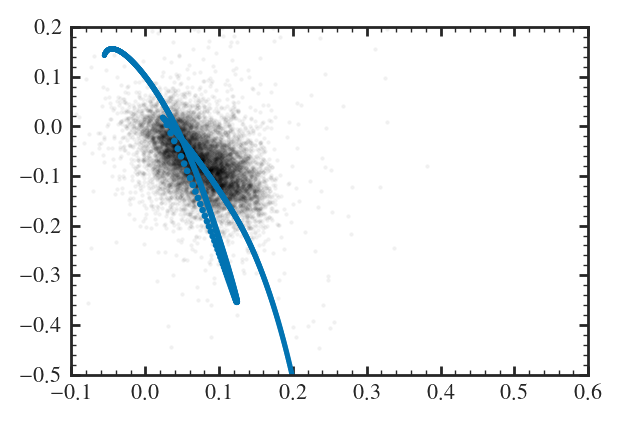

In [44]:
plt.scatter(x, y, s=0.3, alpha=0.05, color="k")
plot_model(model, soln.x)
plt.xlim(-0.1, 0.6)
plt.ylim(-0.5, 0.2)

In [ ]:
Nwalkers = 2*Nparams
pos = soln.x* (1 + 0.01 * np.random.randn(Nwalkers, Nparams))

sampler = emcee.EnsembleSampler(
    Nwalkers, Nparams, model.log_likelihood, args=[obs]
)
sampler.run_mcmc(pos, 100, progress=True)

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

In [50]:
import corner

In [51]:
flat_samples = sampler.get_chain(discard=10, thin=1, flat=True)

AttributeError: you must run the sampler with 'store == True' before accessing the results

In [ ]:
fig = corner.corner(flat_samples, labels=[r"eta", "$tau_agb$", "$f_{\rm agb}$"]);

In [ ]:
sz_params()

In [ ]:
import arya

In [ ]:
arya.medianplot(subgiants, "MG_FE", "C_MG", binsize=100)

In [ ]:
for i in range(len(flat_samples)):
    plot_model(flat_samples[i, :], alpha=0.01, color="blue")

plt.scatter(x, y, s=0.3, alpha=0.05, color="k")
arya.medianplot(subgiants, "MG_FE", "C_MG", binsize=100)
plt.xlim(-0.1, 0.6)
plt.ylim(-0.5, 0.2)